In [2]:
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline
import seaborn as sns
from scipy.optimize import curve_fit
import seaborn as sns

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    


In [3]:
# Define the LL4 model function
def fourpl(x, a, b, c, d):
    #x is the independent variable (i.e., the dose or concentration of the stimulus).
    #a is the upper asymptote of the response (i.e., the maximum possible response).
    #b is the Hill slope or steepness parameter, which determines how quickly the response transitions from the lower plateau to the upper plateau. A larger value of b indicates a steeper curve.
    #c is the EC50 or half-maximal effective concentration, which is the dose that produces a response halfway between the lower and upper plateaus.
    #d is the lower asymptote of the response (i.e., the baseline or background response).
    return d + (a - d) / (1 + (x / c)**b)

def derivative(x, Min, b, c, Max):
    return (b * (Max - Min) * (c**b) * (x**(b - 1))) / (c**b + x**b)**2

# Define the synergy calculation function using ZIP method
def calculate_synergy(viability_drug1, viability_drug2, viability_combination):
    zip_score = viability_combination / (viability_drug1 * viability_drug2)
    synergy_score = 1 - zip_score
    return synergy_score

def getNearest(x, array):
    dif_Array = np.absolute(array-x) # use of absolute() function to find the difference 
    index = dif_Array.argmin() # find the index of minimum difference element
    return index

def getIC50(dose, response, drug, ax):
    #remove negative values:
    mask = response > 0;
    response = response[mask]
    dose = dose[mask]

    #start from the actual minimum value:
    #idx = np.argmin(response);
    #response = response[idx:-1]
    #dose = dose[idx:-1]

    p0 = [np.max(response), 1, (np.mean(dose)), np.min(response)]
    popt, pcov = curve_fit(fourpl, xdata = dose, ydata = response, maxfev = 10000, p0 = p0)
    #popt, pcov = curve_fit(fourpl, xdata = dose, ydata = response, maxfev = 10000, p0 = p0, bounds=([np.min(response), 0.01, np.min(dose), np.min(response)], [np.max(response), 100, np.max(dose), np.max(response)]))
    # Extract the parameters from popt
    Min, b, c, Max = popt
    # Calculate the IC50
    #IC50 = c * (1 + (Max / Min))**(1 / b)
    IC50 = c*2;
    
    # Generate a finer x-axis for plotting the curve
    x_fit = np.linspace(np.min(dose), np.max(dose), 100)
    y_fit = fourpl((x_fit), Min, b, c, Max)
    
    #half_resp = (np.max(y_fit) - np.min(y_fit))/2
    #IC50 = x_fit[getNearest(half_resp, y_fit)]

    slope = derivative(IC50, Min, b, c, Max)

    # Plot the dose-response curve
    ax.scatter(x = dose, y = response, label = 'Data')
    ax.plot(x_fit, y_fit, color = 'r', label='LL4 Fit')

    ax.vlines(IC50, 0, y_fit[getNearest(IC50, x_fit)], colors='k', linestyles='dashed', label = f'IC50 = {IC50:.3f}')
    ax.hlines(y_fit[getNearest(IC50, x_fit)], x_fit[0], x_fit[getNearest(IC50, x_fit)], colors='k', linestyles='dashed')
    ax.set_xscale('log')
    ax.set_xlabel('Dose [log]', fontsize = 14)
    ax.set_ylabel('Normalized Response', fontsize = 14)
    ax.set_ylim([-10, 110])
    ax.set_title(f'{drug} - Min: {Min:.2f}, Max: {Max:.2f}, Slope: {slope:.2f}')
    ax.legend()
    
    return IC50, slope, Min, Max


In [4]:
df = pd.read_csv('/Users/sbk/Documents/Datasets/DrugSynergy/ExampleData/exampleTable/exampleTable.csv')
df = df[df.PairIndex == 1];
df.reset_index(drop = True, inplace=True);
df.head()

,PairIndex,Drug1,Drug2,Conc1,Conc2,Response,ConcUnit
0,1,AT-406,Navitoclax,0.0,0.0,-10.193219,nM
1,1,AT-406,Navitoclax,0.0,1.0,5.915452,nM
2,1,AT-406,Navitoclax,0.0,3.0,7.033741,nM
3,1,AT-406,Navitoclax,0.0,10.0,1.863109,nM
4,1,AT-406,Navitoclax,0.0,30.0,10.190392,nM


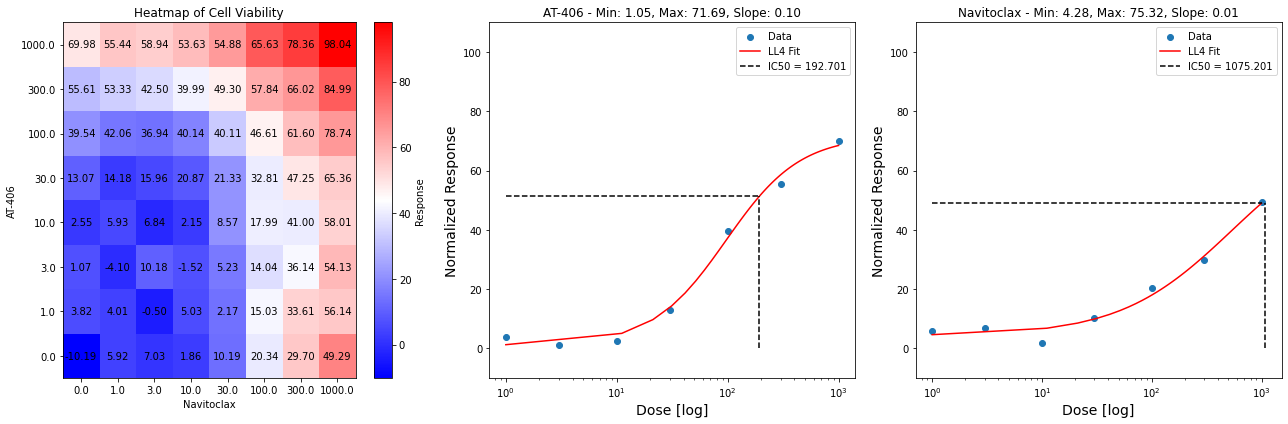

In [46]:
matrix = np.zeros((8,8))
doses1 = np.unique(df.Conc1)
doses2 = np.unique(df.Conc2)
for ix in range(len(doses2)):
    for ij in range(len(doses1)):
        matrix[ix, ij] = df.Response[(df.Conc1 == doses1[ij]) & (df.Conc2 == doses2[ix])]
        

# Plot the heatmap
fig, ax = plt.subplots(1,3,figsize=(18,6))
im = ax[0].imshow(matrix, cmap='bwr', aspect='auto')
fig.colorbar(im, ax=ax[0], label='Response')
for ix in range(len(doses2)):
    for ij in range(len(doses1)):
        text = ax[0].text(ix, ij, f'{matrix[ix, ij]:.2f}',
                       ha="center", va="center", color="k")
ax[0].set_xlabel(np.unique(df.Drug2)[0])
ax[0].set_ylabel(np.unique(df.Drug1)[0])
ax[0].set_xticks(range(len(doses2)), doses1)
ax[0].set_yticks(range(len(doses1)), doses2)
ax[0].invert_yaxis()
ax[0].set_title('Heatmap of Cell Viability')

#Drug1:
edf = df[df.Conc2 == 0];
edf.reset_index(drop = True, inplace = True);
drug1 = np.unique(edf.Drug1)[0]
response1 = edf.Response
IC50_drug1, slope1, min1, max1 = getIC50(doses1, response1, drug1, ax[1])

#Drug1:
edf = df[df.Conc1 == 0];
edf.reset_index(drop = True, inplace = True);
drug2 = np.unique(edf.Drug2)[0]
dose = edf.Conc2
response2 = edf.Response
IC50_drug2, slope2, min2, max2 = getIC50(doses2, response2, drug2, ax[2])

plt.tight_layout()    

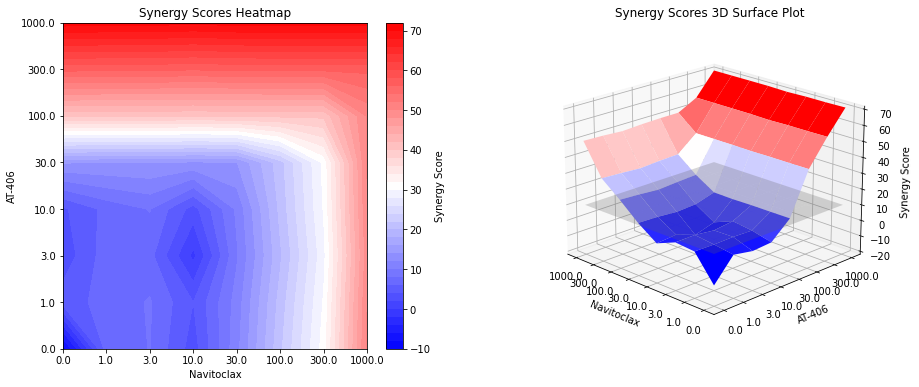

In [126]:
# Define the function to calculate synergy scores
def calculate_synergy_scoresX(response_matrix):
    # Calculate the expected response based on additivity
    response1 = response_matrix[:, 0]; #the y axis
    response2 = response_matrix[0, :]; #the x axis
    expected_response = np.outer(response2, response1)

    # Calculate the synergy scores
    synergy_scores = (response_matrix - expected_response) / expected_response

    # Apply correction using the HSA method
    max_response = np.maximum.outer(response2, response1)
    corrected_synergy_scores = synergy_scores - max_response

    return corrected_synergy_scores

# Define the function to calculate synergy scores
def calculate_synergy_scores(response_matrix, IC50_1, IC50_2):
    # Calculate the expected response based on additivity
    expected_response = np.outer(response_matrix[:, 0], response_matrix[0, :])

    # Calculate the synergy scores
    synergy_scores = (response_matrix - expected_response) / expected_response

    # Apply correction using the HSA method
    corrected_synergy_scores = synergy_scores - (IC50_1[:, np.newaxis] / response_matrix) - (IC50_2[np.newaxis, :] / response_matrix) + (IC50_1[:, np.newaxis] * IC50_2[np.newaxis, :] / response_matrix)

    return corrected_synergy_scores


# Calculate synergy scores
synergy_scores = calculate_synergy_scoresX(matrix)
#synergy_scores = calculate_synergy_scores(matrix, IC50_drug1, IC50_drug2)

# Generate 3D surface plot of synergy scores
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(121)
vmax = 0
vmin = -20

# Generate 2D heatmap of synergy scores
im = ax.contourf(-synergy_scores, cmap='bwr', aspect='auto', levels = 50)
#im = ax.contourf(synergy_scores, cmap='bwr', aspect='auto', levels = 50, vmin = vmin, vmax = vmax)
fig.colorbar(im, ax=ax, label='Synergy Score')
ax.set_xlabel(f'{drug2}')
ax.set_ylabel(f'{drug1}')
ax.set_title('Synergy Scores Heatmap')
ax.set_xticks(range(matrix.shape[1]))
ax.set_yticks(range(matrix.shape[0]))
ax.set_xticklabels(doses2);
ax.set_yticklabels(doses1);

# Generate 3D surface plot of synergy scores
ax = fig.add_subplot(122, projection='3d')
X, Y = np.meshgrid(range(matrix.shape[1]), range(matrix.shape[0]))
Z = synergy_scores
#ax.plot_surface(X, Y, -Z, cmap='bwr', rcount = 100, ccount = 100, vmin = vmin, vmax = vmax)
ax.plot_surface(X, Y, -Z, cmap='bwr', rcount = 100, ccount = 100)

# Create the cytostatic growth rate plane
cytostatic_plane = np.ones(shape = np.shape(Z))*10
ax.plot_surface(X, Y, cytostatic_plane, color='gray', alpha=0.25)  # Plot cytostatic plane
ax.set_xticks(range(matrix.shape[1]))
ax.set_yticks(range(matrix.shape[0]))
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_xticklabels(doses2);
ax.set_yticklabels(doses1);
ax.set_xlabel(f'{drug2}')
ax.set_ylabel(f'{drug1}')
ax.set_zlim([-20, 70])
ax.set_zlabel('Synergy Score')
ax.set_title('Synergy Scores 3D Surface Plot')
ax.view_init(20, -45)

plt.show()


AttributeError: 'list' object has no attribute 'ndim'

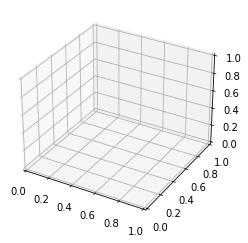

In [122]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define function f as the Hill equation
def hill_equation(D, Emax, EC50, n):
    return Emax * (D**n) / (EC50**n + D**n)

# Define function to calculate Bayesian estimate of actual dose (D_hat)
def calculate_D_hat(D, E, f, epsilon, eta, Emax, EC50, n):
    return D * (E - f(D, Emax, EC50, n)) / (np.log(D) - np.log(D) + epsilon/eta)

D1, D2 = np.meshgrid(doses1, doses2)
E_combined = np.meshgrid(np.array(response1), np.array(response2))
epsilon = 0.1
eta = 0.1

# Calculate Bayesian estimate of actual dose (D_hat)
D1_hat = calculate_D_hat(doses1, response1, hill_equation, epsilon, eta, max1, IC50_drug1, slope1)
D2_hat = calculate_D_hat(doses2, response2, hill_equation, epsilon, eta, max2, IC50_drug2, slope2)


# Plot 3D surface graph
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(D1, D2, E_combined, cmap='viridis', alpha=0.7)
ax.set_xlabel('Dose of Compound 1')
ax.set_ylabel('Dose of Compound 2')
ax.set_zlabel('Effect (Combined)')
plt.show()
